In [1]:
# Required packages for this notebook. Uncomment and run to install.
# pip install qutip tqdm pandas numpy scikit-learn matplotlib

# Imports

In [2]:
from __future__ import annotations
from qutip_qip import operations
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd
import qutip as qp

# Functions

In [3]:
#################################
# DATASET GENERATION
#################################
def rand_uni(case:int | case=0) -> qp.qobj.Qobj:
    """
    Generates a Haar distributed random local unitary in a 3-qubit setup
    case:    which case to use for unitary generation
    """
    uni1 = qp.rand_unitary(2)
    uni2 = qp.rand_unitary(2)
    uni3 = qp.rand_unitary(2)
    id2 = qp.identity(2)
    if case == 0:
        return qp.tensor(id2,id2,id2)
    elif case == 1:
        return qp.tensor(uni1,id2,id2)
    elif case == 2:
        return qp.tensor(id2,uni2,id2)
    elif case == 3:
        return qp.tensor(id2,id2,uni3)
    elif case == 4:
        return qp.tensor(uni1,uni2,id2)
    elif case == 5:
        return qp.tensor(uni1,id2,uni3)
    elif case == 6:
        return qp.tensor(id2,uni2,uni3)
    elif case == 7:
        return qp.tensor(uni1,uni2,uni3)

def w(alpha: complex,
      beta: complex,
      gamma: complex) -> qp.qobj.Qobj:
    """
    Generates a random w state.
    alpha:  amplitude for ket |001>
    beta:  amplitude for ket |010>
    gamma:  amplitude for ket |010>
    """
    alpha_mod_sq = alpha.real**2+alpha.imag**2
    beta_mod_sq = beta.real**2+beta.imag**2
    gamma_mod_sq = gamma.real**2+gamma.imag**2
    normalizer = np.sqrt(alpha_mod_sq + beta_mod_sq + gamma_mod_sq)
    return (alpha*qp.ket("001") + beta*qp.ket("010") + gamma*qp.ket("100"))/normalizer

def state(class_number:int,
          noise:float | noise=0) -> qp.qobj.Qobj:
    """
    Generates a state belonging to a given SLOCC class
    class_number:   the SLOCC class in which the generated state belongs (0-SEP,1-BS1,2-BS2,3-BS3,4-W,5-GHZ)
    noise:          amount of white noise to add to the generated state
    """
    if class_number > 5:
        raise ValueError("Invalid class_number for SLOCC.")
    uni = rand_uni(np.random.randint(8))
    if class_number == 0:
        # rho A|B|C
        psi = qp.tensor(qp.rand_ket([2]),qp.rand_ket([2]),qp.rand_ket([2]))
        psi = uni*psi
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])
    if class_number == 1:
        # rho A|BC
        ket_BC = qp.rand_ket([2,2])
        psi = qp.tensor(qp.rand_ket([2]),ket_BC)
        psi = uni*psi
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])
    elif class_number == 2:
        # rho AB|C
        ket_AB = qp.rand_ket([2,2])
        psi = qp.tensor(ket_AB,qp.rand_ket([2]))
        psi = uni*psi
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])
    elif class_number == 3:
        # rho AC|B
        ket_AC = qp.rand_ket([2,2])
        psi = qp.tensor(ket_AC,qp.rand_ket([2])) # in ACB order
        psi.dims = [[2,2,2],[1,1,1]]
        psi = operations.swap(3,targets=[1,2])*psi # in ABC order
        psi = uni*psi
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])
    elif class_number == 4:
        # rho ABC (W)
        alpha = np.random.uniform(-1, 1) + 1j * np.random.uniform(-1, 1)
        beta = np.random.uniform(-1, 1) + 1j * np.random.uniform(-1, 1)
        gamma = np.random.uniform(-1, 1) + 1j * np.random.uniform(-1, 1)
        state = w(alpha,beta,gamma)
        psi = uni*state
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])
    elif class_number == 5:
        # rho ABC (GHZ)
        psi = qp.rand_ket([2,2,2])
        psi = uni*psi
        return (1-noise)*qp.Qobj(psi*psi.dag(),dims=[[2,2,2],[2,2,2]])+noise*qp.identity([2,2,2])

def generate(N:int,
             seed:int | seed=None,
             noise:float | noise=0) -> list[list[qp.qobj.Qobj,int]]:
    """
    Generates the 3-qubit SLOCC dataset
    N:       number of states to generate
    seed:    random number seed to use
    noise:   amount of white noise to add to the generated states
    """
    states = {0:[],1:[],2:[],3:[],4:[],5:[]}
    if seed is not None:
        np.random.seed(seed)
    for __ in tqdm(range(N),position=0,leave=True):
        for class_number in range(6):
            rho = state(class_number,noise)
            states[class_number].append(rho)
    return [[states[i],i] for i in range(6)]

def generateClass(N:int,
                  dataset_class:int | dataset_class=0,
                  seed:int | seed=None,
                  noise:float | noise=0) -> list[list[qp.qobj.Qobj,int]]:
    """
    Generates 3-qubit states of a given SLOCC class
    N:              number of states to generate
    dataset_class:  the SLOCC class for which to generate data (0-SEP,1-BS1,2-BS2,3-BS3,4-W,5-GHZ)
    seed:           random number seed to use
    noise:          amount of white noise to add to the generated states
    """
    states = []
    if seed is not None:
        np.random.seed(seed)
    for __ in tqdm(range(N),position=0,leave=True):
        rho = state(dataset_class,noise)
        states.append(rho)
    return states

#################################
# FEATURE EXTRACTION
#################################
def feature_list(states) -> list[list[float]]:
    """
    Converts the quantum state's density matrix's real and imaginary elements into a list.
    states:     list of states
    """
    features = []
    for rho in states:
        matrix = rho.data.to_array()
        reals = list(np.real(matrix).flatten())
        imags = list(np.imag(matrix).flatten())
        features.append(reals+imags)
    return features

# Dataset
Generate states for training and testing

In [4]:
#################################
# TRAINING SET
#################################
states_train = generate(1000000,seed=0)

#################################
# TEST SET
#################################
states_test = generate(1000,seed=10)

  0%|          | 0/1000000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Feature Extraction
Remove redundant elements of the density matrix.<br>
Remaining elements are flattened into real+imaginary array to be used as input features for ANN models.<br>
Lables are assinged to the features depending on the SLOCC class of the state.

In [10]:
class_dictionary = {0:'SEP',1:'BS1',2:'BS2',3:'BS3',4:'W',5:'GHZ'}

#################################
# All Density Matrix Element Names for 3-qubit System
#################################
N = 64
rho_elements = [None]*(2*N)
k = 0
for i in range(8):
    for j in range(8):
        rho_elements[k] = f"Rho_{str(i)}_{str(j)}_Real"
        rho_elements[N+k] = f"Rho_{str(i)}_{str(j)}_Imag"
        k += 1

#################################
# Removing redundant elements
#################################
bin_list = ["000","001","010","011","100","101","110","111"]
int_list = [int(i,2) for i in bin_list]
index_list = [[i,j] for i in int_list for j in int_list]

# remove conjugate transposed elements - removing lower triangular part
for i in range(8):
    for j in range(0,i):
        index_list.remove([i,j])
# removing last main diagonal element - Normalization condition
index_list.remove([7,7])

real_coord = index_list
imag_coord = []
for i in range(8):
    for j in range(i+1,8):
        imag_coord.append([i,j])

#################################
# Final Density Matrix Element Names for 3-qubit System
#################################
column_names = []
for re in real_coord :
    column_names.append(f"Rho_{re[0]}_{re[1]}_Real")
for im in imag_coord :
    column_names.append(f"Rho_{im[0]}_{im[1]}_Imag")
n_features = len(column_names)

In [11]:
print("Extracting Features")

#################################
# TRAINING SET
#################################
featured_states = []
for slocc_class in range(6):
    x = feature_list(states_train[slocc_class][0])
    featured_states.append([x,slocc_class])

    # DataFrame and CSV files for individual SLOCC classes
    label = [0,0,0,0,0,0]
    label[slocc_class] = 1
    label.append(states_train[slocc_class][1])
    y = [label]*len(x)
    x = np.array(x)
    
    dfx = pd.DataFrame(x)
    dfy = pd.DataFrame(y)
    dfx.columns = rho_elements
    dfx = dfx[column_names]
    dfy.columns = ['FS', 'BS1', 'BS2', 'BS3', 'W', 'GHZ','CODE']
    data = pd.concat([dfx,dfy],axis=1)
    data = data.sample(frac=1).reset_index(drop=True)
    data.to_csv(f"test_train_data/individual_classes/{class_dictionary[slocc_class]}.csv")
    print(f"\tTraining set SLOCC Class {slocc_class} exported to test_train_data/individual_classes/{class_dictionary[slocc_class]}.csv")

# DataFrame and CSV files (Combined SLOCC Classes)
x = []
y = []
for i in range(len(states_train)):
    x += featured_states[i][0]
    label = [0,0,0,0,0,0]
    label[featured_states[i][1]] = 1
    label.append(featured_states[i][1])
    y += [label]*len(featured_states[i][0])
x = np.array(x)

dfx = pd.DataFrame(x)
dfy = pd.DataFrame(y)
dfx.columns = rho_elements
dfx = dfx[column_names]
dfy.columns = ['FS', 'BS1', 'BS2', 'BS3', 'W', 'GHZ','CODE']
data = pd.concat([dfx,dfy],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv("test_train_data/train.csv")
print(f"\tTraining set exported to test_train_data/train.csv")
print("\033[F\x1b[2KTrain Set: Done")

#################################
# TEST SET
#################################
featured_states = []
for slocc_class in range(6):
    result = feature_list(states_test[slocc_class][0])
    featured_states.append([result,slocc_class])

# DataFrame and CSV files (Combined SLOCC Classes)
x = []
y = []
for i in range(len(states_test)):
    x += featured_states[i][0]
    label = [0,0,0,0,0,0]
    label[featured_states[i][1]] = 1
    label.append(featured_states[i][1])
    y += [label]*len(featured_states[i][0])
x = np.array(x)

dfx = pd.DataFrame(x)
dfy = pd.DataFrame(y)
dfx.columns = rho_elements
dfx = dfx[column_names]
dfy.columns = ['FS', 'BS1', 'BS2', 'BS3', 'W', 'GHZ','CODE']
data = pd.concat([dfx,dfy],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv("test_train_data/test.csv")
print(f"\tTest set exported to test_train_data/test.csv")
data.to_csv("test_train_data/hierarchical/test_final.csv")
print("\033[F\x1b[2KTest Set: Done")

Extracting Features
	Training set SLOCC Class 0 exported to test_train_data/individual_classes/SEP.csv
	Training set SLOCC Class 1 exported to test_train_data/individual_classes/BS1.csv
	Training set SLOCC Class 2 exported to test_train_data/individual_classes/BS2.csv
	Training set SLOCC Class 3 exported to test_train_data/individual_classes/BS3.csv
	Training set SLOCC Class 4 exported to test_train_data/individual_classes/W.csv
	Training set SLOCC Class 5 exported to test_train_data/individual_classes/GHZ.csv
	Training set exported to test_train_data/train.csv
Train Set: Done
	Test set exported to test_train_data/test.csv
Test Set: Done


# Feature Importance Analysis (ANOVA)
Using Univariate ANOVA F-Test, assign importance scores to each feature.<br>
Higher the score, more useful is the feature for the SLOCC classification task.

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("test_train_data/train.csv",index_col=0)
X = df.iloc[:,0:n_features]
Y = df.iloc[:,-1]

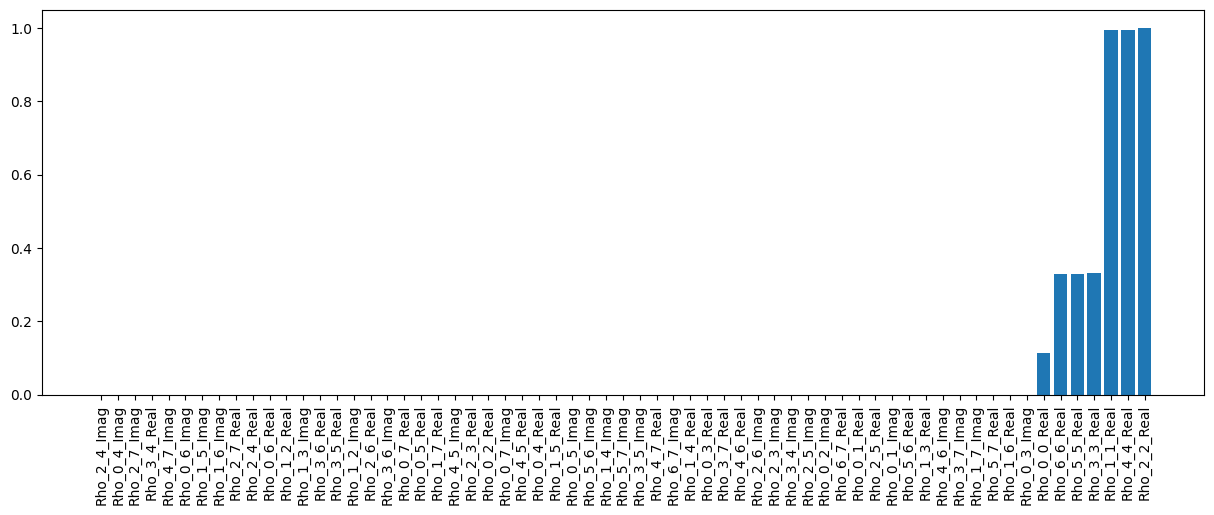

In [14]:
k = n_features # Number of features to rank

# Selecting k best features out of n features
test = SelectKBest(score_func=f_classif, k=k)
fit = test.fit(X,Y)

# Summarize Scores
features = X.columns.values.tolist()
feature_scores = list(fit.scores_)
max_score_value = np.max(feature_scores)
feature_scores = [score/(max_score_value) for score in feature_scores] # Normalized scores

feature_dict = {k:v for (k,v) in zip(features,feature_scores)}
D = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1])}

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(range(k), list(list(D.values())[len(D)-k:]), align='center')
plt.xticks(range(k), list(D.keys())[len(D)-k:])
plt.show()

<hr>

# Hierarchical Model Data
Format the test data as appropriate for each hierarchical model:
1. FS vs NOT model
2. BS vs GME Model
3. W vs GHZ model

In [16]:
# number of states per SLOCC class
n_states = len(states_test[0][0])

#################################
# FS-NOT
#################################
fs = states_test[0][0]
# to keep the class of states (BS,GME) uniform in the NOT-FS category
class_contibution = n_states//5
not_fs = []
for i in range(1,6):
    not_fs += states_test[i][0][:class_contibution]
test_fs_not = [[fs,0],[not_fs,1]]

featured_states = []
for slocc_class in range(2):
    result = feature_list(test_fs_not[slocc_class][0])
    featured_states.append([result,slocc_class])
x = []
y = []
for i in range(len(test_fs_not)):
    x += featured_states[i][0]
    label = [0,0]
    label[featured_states[i][1]] = 1
    label.append(featured_states[i][1])
    y += [label]*len(featured_states[i][0])
x = np.array(x)
dfx = pd.DataFrame(x)
dfy = pd.DataFrame(y)
dfx.columns = rho_elements
dfx = dfx[column_names]
dfy.columns = ["FS", "NOT", "CODE"]
data = pd.concat([dfx,dfy],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv("test_train_data/hierarchical/test_fs.csv")
print(f"FS vs NOT Test set exported to test_train_data/hierarchical/test_fs.csv")


#################################
# BS-GME
#################################
bs1 = states_test[1][0]
bs2 = states_test[2][0]
bs3 = states_test[3][0]
# to keep the class of states (W,GHZ) uniform in the GME category
class_contibution = n_states//2
gme = []
for i in range(4,6):
    gme += states_test[i][0][:class_contibution]
test_bs_gme = [[bs1,0],[bs2,1],[bs3,2],[gme,3]]

featured_states = []
for slocc_class in range(4):
    result = feature_list(test_bs_gme[slocc_class][0])
    featured_states.append([result,slocc_class])
x = []
y = []
for i in range(len(test_bs_gme)):
    x += featured_states[i][0]
    label = [0,0,0,0]
    label[featured_states[i][1]] = 1
    label.append(featured_states[i][1])
    y += [label]*len(featured_states[i][0])
x = np.array(x)
dfx = pd.DataFrame(x)
dfy = pd.DataFrame(y)
dfx.columns = rho_elements
dfx = dfx[column_names]
dfy.columns = ["BS1","BS2","BS3","GME","CODE"]
data = pd.concat([dfx,dfy],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv("test_train_data/hierarchical/test_bs_gme.csv")
print(f"BS vs GME Test set exported to test_train_data/hierarchical/test_bs_gme.csv")

#################################
# W-GHZ
#################################
test_w_ghz = [[states_test[4][0],0],[states_test[5][0],1]]
featured_states = []
for slocc_class in range(2):
    result = feature_list(test_w_ghz[slocc_class][0])
    featured_states.append([result,slocc_class])
x = []
y = []
for i in range(len(test_w_ghz)):
    x += featured_states[i][0]
    label = [0,0]
    label[featured_states[i][1]] = 1
    label.append(featured_states[i][1])
    y += [label]*len(featured_states[i][0])
x = np.array(x)
dfx = pd.DataFrame(x)
dfy = pd.DataFrame(y)
dfx.columns = rho_elements
dfx = dfx[column_names]
dfy.columns = ["W","GHZ","CODE"]
data = pd.concat([dfx,dfy],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv("test_train_data/hierarchical/test_w_ghz.csv")
print(f"W vs GHZ Test set exported to test_train_data/hierarchical/test_w_ghz.csv")

FS vs NOT Test set exported to test_train_data/hierarchical/test_fs.csv
BS vs GME Test set exported to test_train_data/hierarchical/test_bs_gme.csv
W vs GHZ Test set exported to test_train_data/hierarchical/test_w_ghz.csv
